# CREATION D'UN INDICATEUR PTAL - CAM


Données GTFS du SMTC

## Chargement librairies et fichiers

In [1]:
import pandas as pd
import geopandas as gpd
import warnings
from pyproj import Proj, transform
import geopandas as gpd
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')

import numpy as np

In [2]:
stops = pd.read_csv(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\GTFS-SMTC\stops.txt')
stops.drop(columns=['stop_code','stop_name','location_type','parent_station'],inplace=True)
stops.head(2)

,stop_id,stop_lat,stop_lon
0,3377704015495200,45.7918,3.16119
1,3377704015495197,45.7929,3.08435


In [3]:
stops_time = pd.read_csv(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\GTFS-SMTC\stop_times.txt')
stops_time.drop(columns=['stop_sequence',
                         'stop_headsign','pickup_type',
                         'drop_off_type','shape_dist_traveled', 'arrival_time','departure_time'],
               inplace=True)

# stops_time = stops_time.groupby('stop_id').count().reset_index()#['trip_id']
stops_time

,trip_id,stop_id
0,4503749951309949,3377704015495958
1,4503749951309949,3377704015495823
2,4503749951309949,3377704015495610
3,4503749951309949,3377704015495861
4,4503749951309949,3377704015495320
...,...,...
200668,4503754246195130,3377704015495593
200669,4503754246195130,3377704015495658
200670,4503754246195130,3377704015495238
200671,4503754246195130,3377704015496225


In [4]:
routes = pd.read_csv(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\GTFS-SMTC\routes.txt')

routes.drop(columns=['agency_id','route_desc','route_url',
                     'route_color','route_text_color', 'route_long_name','route_type']
            ,inplace=True)
type_ligne=[]
for num in routes.route_short_name:
    if (num == 'A'):
        type_ligne.append('tram') 
    elif (num == 'B') or (num == 'C'):
#         print('bhns')
        type_ligne.append('bhns')
    else:
        type_ligne.append('bus')
routes['type_ligne'] = type_ligne#
routes.head(5)

,route_id,route_short_name,type_ligne
0,11821953316814874,10,bus
1,11821953316814875,12,bus
2,11821953316814876,13,bus
3,11821953316814877,20,bus
4,11821953316814878,21,bus


In [5]:
trips = pd.read_csv(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\GTFS-SMTC\trips.txt')
trips.drop(columns=['trip_headsign','direction_id','shape_id','service_id'],inplace=True)
trips.head(4)

,trip_id,route_id
0,4503749951309949,11821953316814895
1,4503749951317232,11821953316814885
2,4503749951317240,11821953316814885
3,4503749951317244,11821953316814885


## Création d'une table des arrets

latitude, longitude, type (car, train,etc)

pour avoir ça :
- il faut récupérer par arrêt le nombre de passage quotidien par ligne
- fusionner le fichier routes (clé route_id) pour avoir le route_id avec le num de la ligne, avec le fichier trip, le fichier trips avec le fichier stop times (clés trip_id)

     - 

In [6]:
a = routes.merge(trips)
b = a.merge(stops_time)
### fichier "complet" : par arrets : toutes les lignes avec le total des passages par jour et la localisation de l'arret
complet = b.merge(stops)
# complet.groupby()
complet.drop(columns=['route_id', 'route_short_name','stop_lat','stop_lon'],inplace=True)
arret_passage_type = complet.groupby(['stop_id','type_ligne']).count().reset_index()

arret_passage_type = arret_passage_type.merge(stops)
arret_passage_type
# stops_time#.merge(a,left_on='trip_id',right_on='trip_id',how='right')

,stop_id,type_ligne,trip_id,stop_lat,stop_lon
0,3377704015495197,bus,9,45.7929,3.08435
1,3377704015495198,bus,8,45.7930,3.08430
2,3377704015495199,bus,2,45.7296,3.18219
3,3377704015495200,bus,101,45.7918,3.16119
4,3377704015495201,bus,102,45.7918,3.16160
...,...,...,...,...,...
1276,3377850044383288,bus,19,45.7338,3.14436
1277,3377850044383291,bus,1,45.8306,3.10539
1278,3377850044383292,bus,1,45.8359,3.10195
1279,3377850044383293,bus,1,45.8355,3.09617


Changement de projection (wgs -> lambert 93)

In [7]:
outProj = Proj(init='epsg:2154')
inProj = Proj(init='epsg:4326')   
table_arrets = arret_passage_type.copy()
table_arrets['stop_lon_l'],table_arrets['stop_lat_l'] = transform(inProj,
                                                                  outProj,
                                                                  table_arrets.stop_lon,
                                                                  table_arrets.stop_lat)
table_arrets.head(3)

,stop_id,type_ligne,trip_id,stop_lat,stop_lon,stop_lon_l,stop_lat_l
0,3377704015495197,bus,9,45.7929,3.08435,706552.661685,6.521479e+06
1,3377704015495198,bus,8,45.7930,3.08430,706548.765621,6.521490e+06
2,3377704015495199,bus,2,45.7296,3.18219,714169.492451,6.514462e+06


In [8]:
gdf_arrets = gpd.GeoDataFrame(table_arrets,geometry=gpd.points_from_xy(table_arrets.stop_lon_l,
                                                                                       table_arrets.stop_lat_l))
gdf_arrets.to_file(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\arrets')

## Chargement du fichier 'centroides' des communes

C'est tout

In [9]:
# On charge les centres des carreaux
# centroides_communes =  gpd.read_file(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\carreaux_cam.geojson')
centroides_communes =  gpd.read_file(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\carreau_100x.shp')

centroides_communes['x'] = centroides_communes.centroid.x
centroides_communes['y'] = centroides_communes.centroid.y
centroides_communes#.head(5)

,id,left,top,right,bottom,geometry,x,y
0,34804.0,712265.0,6523059.0,712365.0,6522959.0,"POLYGON ((712265.000 6523059.000, 712365.000 6...",712315.000000,6.523009e+06
1,34805.0,712265.0,6522959.0,712365.0,6522859.0,"POLYGON ((712265.000 6522959.000, 712365.000 6...",712315.000000,6.522909e+06
2,34806.0,712265.0,6522859.0,712365.0,6522759.0,"POLYGON ((712265.000 6522859.000, 712365.000 6...",712315.000000,6.522809e+06
3,34807.0,712265.0,6522759.0,712365.0,6522659.0,"POLYGON ((712265.000 6522759.000, 712365.000 6...",712315.000000,6.522709e+06
4,34808.0,712265.0,6522659.0,712365.0,6522559.0,"POLYGON ((712265.000 6522659.000, 712365.000 6...",712315.000000,6.522609e+06
...,...,...,...,...,...,...,...,...
31049,26434.0,708265.0,6528059.0,708365.0,6527959.0,"POLYGON ((708265.000 6528059.000, 708365.000 6...",708315.000000,6.528009e+06
31050,26435.0,708265.0,6527959.0,708365.0,6527859.0,"POLYGON ((708265.000 6527959.000, 708365.000 6...",708315.000000,6.527909e+06
31051,26436.0,708265.0,6527859.0,708365.0,6527759.0,"POLYGON ((708265.000 6527859.000, 708365.000 6...",708315.000000,6.527809e+06
31052,26437.0,708265.0,6527759.0,708365.0,6527659.0,"POLYGON ((708265.000 6527759.000, 708365.000 6...",708315.000000,6.527709e+06


## Creation de tables temporaires

On trie par train, car

In [10]:

bus = table_arrets[table_arrets['type_ligne']=='bus']
t_bus = bus[bus['trip_id']>5]
t_bus = bus.drop(columns=['stop_id','stop_lat','stop_lon','type_ligne']).reset_index()
t_bus=t_bus.drop(columns=['index'])


tram = table_arrets[table_arrets['type_ligne']=='tram']
t_tram = tram.drop(columns=['stop_id','stop_lat','stop_lon','type_ligne']).reset_index()
t_tram=t_tram.drop(columns=['index'])
t_tram.head(3)

bhns = table_arrets[table_arrets['type_ligne']=='bhns']
t_bhns = bhns.drop(columns=['stop_id','stop_lat','stop_lon','type_ligne']).reset_index()
t_bhns=t_bhns.drop(columns=['index'])
t_bhns.head(3)

t_bus


,trip_id,stop_lon_l,stop_lat_l,geometry
0,9,706552.661685,6.521479e+06,POINT (706552.662 6521478.818)
1,8,706548.765621,6.521490e+06,POINT (706548.766 6521489.919)
2,2,714169.492451,6.514462e+06,POINT (714169.492 6514462.148)
3,101,712522.158128,6.521366e+06,POINT (712522.158 6521365.944)
4,102,712554.009221,6.521366e+06,POINT (712554.009 6521366.009)
...,...,...,...,...
1103,19,711226.484724,6.514922e+06,POINT (711226.485 6514922.477)
1104,1,708181.548435,6.525667e+06,POINT (708181.548 6525667.385)
1105,1,707913.737469,6.526256e+06,POINT (707913.737 6526255.602)
1106,1,707465.126741,6.526211e+06,POINT (707465.127 6526210.619)


### table communale

Avec X, Y et le nom de la commune, pour pouvoir fusionner avec le shapefile

In [11]:
communes = pd.DataFrame()
communes['X_COM'] = centroides_communes.x
communes['Y_COM'] = centroides_communes.y
communes['nom'] = centroides_communes.id#Id_carr1km
communes.drop_duplicates('nom',inplace=True)

## Calcul du PTAL


Le ptal se calcule pour chaque localité (ici communes)
    on prend l'ensemble des arrets car/trains pour un rayon de :
    
    -5km pour les cars
    -10 km pour les trains
    
il faut donc faire une boucle en itérant sur chaque commune :

    1 - on calcule les distances eucliediennes avec les arrets
    2 - on sort les arrets trop éloignés
    3 - on calcule le ptal pour la commune

In [15]:
ptal_ = list()
commune = list()

for idx, p in zip(communes.index, tqdm(communes.index)):
    
    com = communes[communes.index==idx]
    
    df_temp_tram = t_tram.copy()
    df_temp_bus = t_bus.copy()
    df_temp_bhns = t_bhns.copy()
    
    # CALCUL PTAL 
    
    distance_t = (((int(com.X_COM.values)- df_temp_tram.stop_lon_l)**2
                      + (int(com.Y_COM.values)- df_temp_tram.stop_lat_l)**2)**0.5)/1000
    
    df_temp_tram['distance'] = distance_t
    df_temp_tram = df_temp_tram[df_temp_tram['distance']<=1]
    
    # on tente la suite d'opérations
    # si echec, cela veut dire qu'il n'y a pas d'arrêt, donc edf = 0
    try:
        SAP = df_temp_tram.distance/(4/3.6) # temps d'acces
        SWT = 0.5*20/df_temp_tram.trip_id #frequence : nombre de passages / par 20h : amplitude horaire
        AWT = 0.75 #pondération pour les tram
        TAT = SAP + SWT + AWT
        EDF = 0.5*(60/min(TAT))
    except:
        EDF = 0
        SWT = 0

    # CALCUL PTAL CARS 
    # meme schema que pour les trains
    distance_c = (((int(com.X_COM.values)- df_temp_bus.stop_lon_l)**2
                      + (int(com.Y_COM.values)- df_temp_bus.stop_lat_l)**2)**0.5)/1000
    df_temp_bus['distance'] = distance_c
    df_temp_bus = df_temp_bus[df_temp_bus['distance']<=0.3]
    try:
        SAP = df_temp_bus.distance/(4/3.6)
        SWT = 0.5*20/df_temp_bus.trip_id #frequence : nombre de passages / par 20h : amplitude horaire
        AWT = 2 #pondération pour les bus
        TAT = min(SAP + SWT + AWT)
        EDF_car = 0.5*(60/TAT)
    except:
        EDF_car = 0
        SWT = 0
        
    distance_b = (((int(com.X_COM.values)- df_temp_bhns.stop_lon_l)**2
                      + (int(com.Y_COM.values)- df_temp_bhns.stop_lat_l)**2)**0.5)/1000
    df_temp_bhns['distance'] = distance_c
    df_temp_bhns = df_temp_bhns[df_temp_bhns['distance']<=0.750]
    try:
        SAP = df_temp_bhns.distance/(4/3.6)
        SWT = 0.5*20/df_temp_bhns.trip_id #frequence : nombre de passages / par 20h : amplitude horaire
        AWT = 2 #pondération pour les bus
        TAT = min(SAP + SWT + AWT)
        EDF_bhns = 0.5*(60/TAT)
    except:
        EDF_bhns = 0
        SWT = 0
        
    if np.isnan(EDF_car)==True:
        EDF_car = 0
    if np.isnan(EDF)==True:
        EDF = 0
    if np.isnan(EDF_bhns)==True:
        EDF_bhns = 0

    if str(com.nom.values[0])=='CRS3035RES1000mN2544000E3784000':
        print(df_temp_tram, df_temp_bus, df_temp_bhns)
        print(EDF_car)
        t = df_temp_tram
        c = df_temp_bus
        et = EDF
        ec = EDF_car
        print(1*EDF + 0.5*EDF_car)

    # calcul ptal avec une pondération : 1 pour les trains, 0.5 pour les cars
    ptal_.append(1*EDF + 0.5*EDF_car + 0.5*EDF_bhns)
    commune.append(str(com.nom.values[0]))


  0%|          | 0/31054 [00:00<?, ?it/s]

### On créé un dataframe temporaire qui contient la commune et le ptal

In [16]:
df_test = pd.DataFrame()
df_test['commune'] = commune
df_test['commune'] = df_test['commune'].astype(str)

df_test['ptal'] = ptal_
df_test.fillna(0,inplace=True)
df_test#.sort_values('ptal')

,commune,ptal
0,34804.0,0.000000
1,34805.0,0.000000
2,34806.0,0.000000
3,34807.0,0.000000
4,34808.0,0.000000
...,...,...
31049,26434.0,6.132632
31050,26435.0,6.340354
31051,26436.0,6.124560
31052,26437.0,5.907929


# fusion avec le geodataframe des communes AURA

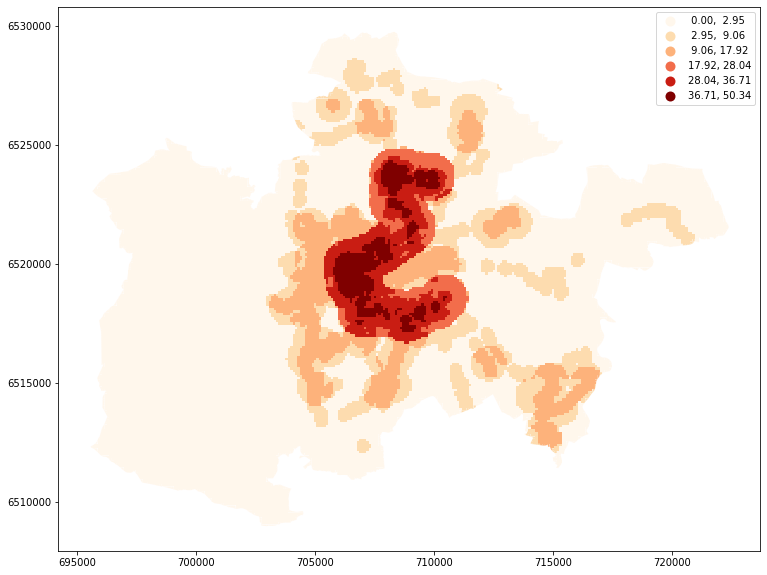

In [14]:

gdf = centroides_communes.copy() #gpd.read_file(r'E:/DOCUMENTS/SIG/carto_pdd/communes_ptal/communes.shp')
gdf['id'] = gdf['id'].astype(str)
ptal = gdf.merge(df_test, left_on='id', right_on='commune',how='left')
ptal.plot(column='ptal', figsize=(15,10), cmap='OrRd', scheme='natural_breaks', legend=True, k=6)


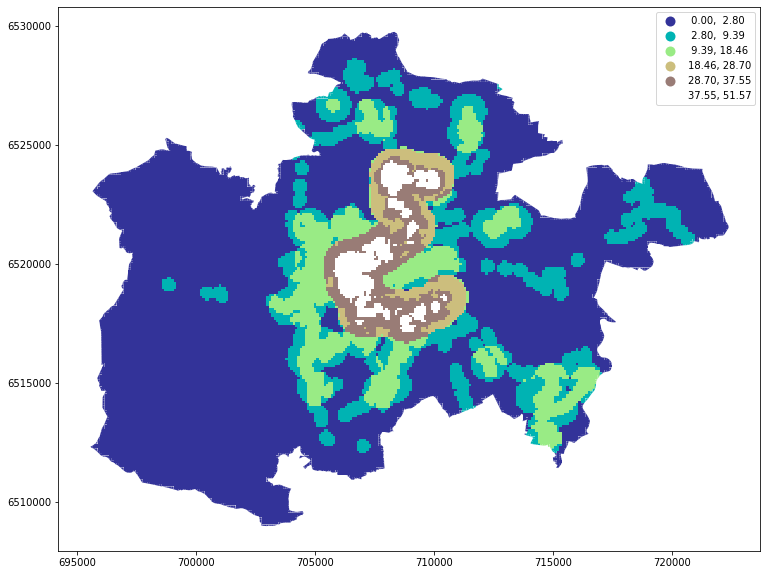

In [21]:

gdf = centroides_communes.copy() #gpd.read_file(r'E:/DOCUMENTS/SIG/carto_pdd/communes_ptal/communes.shp')
gdf['id'] = gdf['id'].astype(str)
ptal = gdf.merge(df_test, left_on='id', right_on='commune',how='left')
ptal.plot(column='ptal', figsize=(15,10), cmap='terrain', scheme='natural_breaks', legend=True, k=6)


In [18]:
ptal.to_file(r'E:\DOCUMENTS\SIG\carto_ptal\PTAL_CAM\100x_2')